In [44]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import json
import data
import tqdm
import skimage.measure


In [45]:
desc = json.load(open('data/track_configuration.json'))
img = np.zeros((3100, 4000), dtype=int)
for shape in desc['shapes']:
    lb, rt = data.get_bounding_box(shape)
    lb[0] = max(lb[0], 0)
    lb[1] = max(lb[1], 0)
    rt[0] = min(rt[0], img.shape[1] - 1)
    rt[1] = min(rt[1], img.shape[0] - 1)
    for i in range(int(lb[0] - 1), int(rt[0] + 1)):
        for j in range(int(lb[1] - 1), int(rt[1] + 1)):
            if data.detect(i, j, shape):
                img[j][i] = 1
                
while img.shape[0] > 1000:
    img = skimage.measure.block_reduce(img, (2,2), np.max)

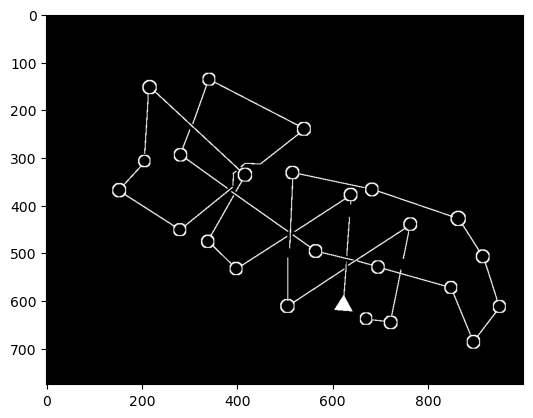

In [46]:
plt.imshow(img, cmap='gray')

In [90]:
def circle_mask(c, shape):
    mask = np.zeros((shape[0],shape[1],1), np.uint8)
    cv2.circle(mask,(c[1],c[0]),c[2],1,10)
    return mask

def check(c, img):
    mask = circle_mask(c, img.shape)
    res = cv2.bitwise_xor(img, mask)
    a = int(np.sqrt(2)/2 * c[2]) - 1
    res_square = res[c[0]-a:c[0] + a, c[1] - a:c[1]+a]
#     plt.imshow(img[c[0] - c[2]: c[0] + c[2], c[1] - c[2]:c[1] + c[2]])
#     plt.show()
#     print(res_square.max())
    return res_square.sum() < 0.02 * 255 * (4 * a * a)

def hough_circle_fixed_radius(img, r):
    img8 = np.uint8(img * 255)
    res = np.zeros_like(img)
    n, m = img.shape
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
    course = cv2.dilate(img8, kernel)
    plt.imshow(course)
    plt.show()
    
    for i in tqdm.tqdm(range(0, n, 2)):
        for j in range(0, m, 2):
            if course[i,j] == 255:
                res += circle_mask((i,j,r), course.shape).reshape((n, m))
    threshold = 0.8 * res.max()
    res[res < threshold] = 0
    print(res.max())
    n_res = res.copy()
    course = cv2.erode(course, kernel)
    
    for i in tqdm.tqdm(range(0, n, 2)):
        for j in range(0, m, 2):
            if res[i,j] >= threshold and check((i, j, r), course):
                n_res += circle_mask((i,j,r), course.shape).reshape((n, m)) * int(threshold)
    return n_res

def detect_circles(img):
    img = np.uint8(img * 255)
    res = np.zeros_like(img * 50)
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=40,minRadius=0,maxRadius=1000)
    if circles is None:
        return
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        i[2] += 50
        if check(i, img):
            cv2.circle(res,(i[0],i[1]),i[2],255,10)
#     cnts = cv2.findContours(course, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     cnts = cnts[0] if len(cnts) == 2 else cnts[1]
#     for c in cnts:
#         area = cv2.contourArea(c)
#         if area < 10 or len(c) < 5:
#             continue
#         ellipse = cv2.fitEllipse(c)
#         print(ellipse[1])
#         if abs(ellipse[1][0] - ellipse[1][1]) > 10:
#             continue
#         cv2.ellipse(img, ellipse, 127, 10)
    plt.imshow(res, cmap='gray')
    plt.show()


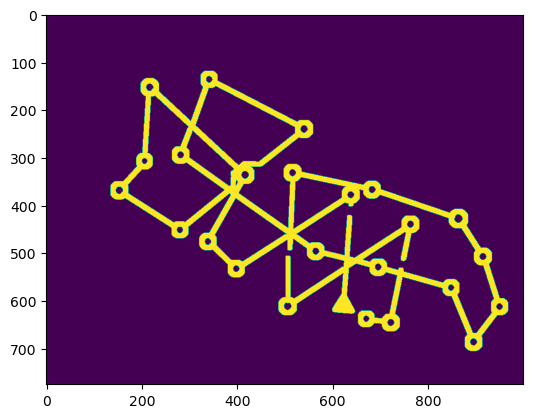

100%|█████████████████████████████████████████| 388/388 [00:26<00:00, 14.51it/s]


208


100%|████████████████████████████████████████| 388/388 [00:00<00:00, 495.68it/s]


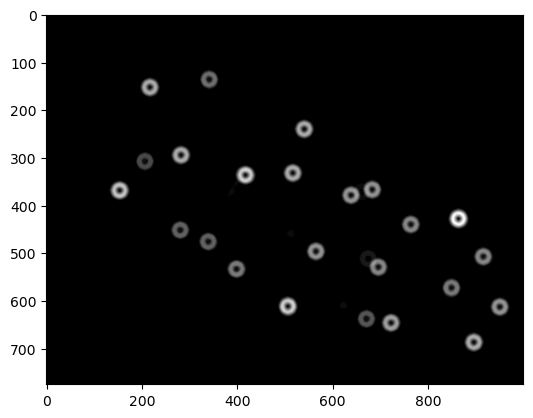

In [91]:
circles = hough_circle_fixed_radius(img, 12)
circles += circle_mask((12, 12, 12), circles.shape).reshape(circles.shape)
plt.imshow(circles, cmap='gray')
plt.show()
